In [1]:
import networkx as nx  
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister 
from qiskit import Aer, execute
from qiskit.circuit import Parameter 
import numpy as np
%matplotlib inline


In [2]:
def create_qaoa_circ(Graph, theta): #G is a graph and theta is a list with all the parameters

    
    qubits= len(Graph.nodes())
    thetas=np.array(theta)
    p=thetas.size//2
    circuit=QuantumCircuit(qubits) 
    
    beta= theta[:p]
    gamma= theta[p:] 
    
    
    for i in range(0,qubits):
        
        circuit.h(i) 
    
    for irep in range(0, p):
        
        for n in list(Graph.edges()):
            
            circuit.rzz(2*gamma[irep],n[0],n[1])
            circuit.barrier()
    
        for i in range(0,qubits):
            
            circuit.rx(2*beta[irep],i) 
        
    circuit.measure_all()
    
    return circuit  

def maxcut(x,G):
    c=0
    for i,j in G.edges(): 
        if x[i] != x[j]: 
            c -= 1 
    return c 

def compute_expectation_value(counts,G):
    
    avg=0
    sum_count=0
    
    for result,i in counts.items(): 
        
        obj= maxcut(result,G) 
        avg += obj * i  
        sum_count += i
    
    return avg/sum_count 


def get_expectation(G,p,shots=512):
    
    backend= Aer.get_backend("qasm_simulator")
    backend.shots=shots
    
    def execute_circ(theta):
        circuit = create_qaoa_circ(Graph, theta) 
        counts= backend.run(circuit, seed_simulator=10, nshots=shots).result().get_counts() 
        
        return compute_expectation_value(counts,G)
    
    return execute_circ
    

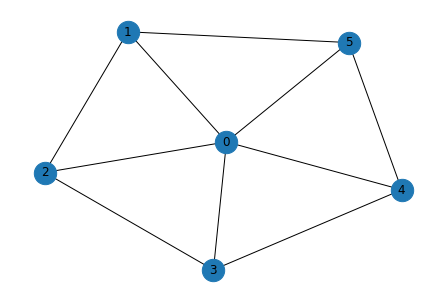

In [3]:
Graph= nx.Graph()
Graph.add_nodes_from([0,1,2,3,4,5])
Graph.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,5),(5,0),(0,3),(4,0),(0,2),(5,1)])
nx.draw(Graph,with_labels=True, alpha=1, node_size=500)

In [4]:
from scipy.optimize import minimize 

expectation= get_expectation(Graph,p=1)

res=minimize(expectation,[1.0,1.0], method="COBYLA") 

res

     fun: -6.017578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.2602665 , 1.32480188])

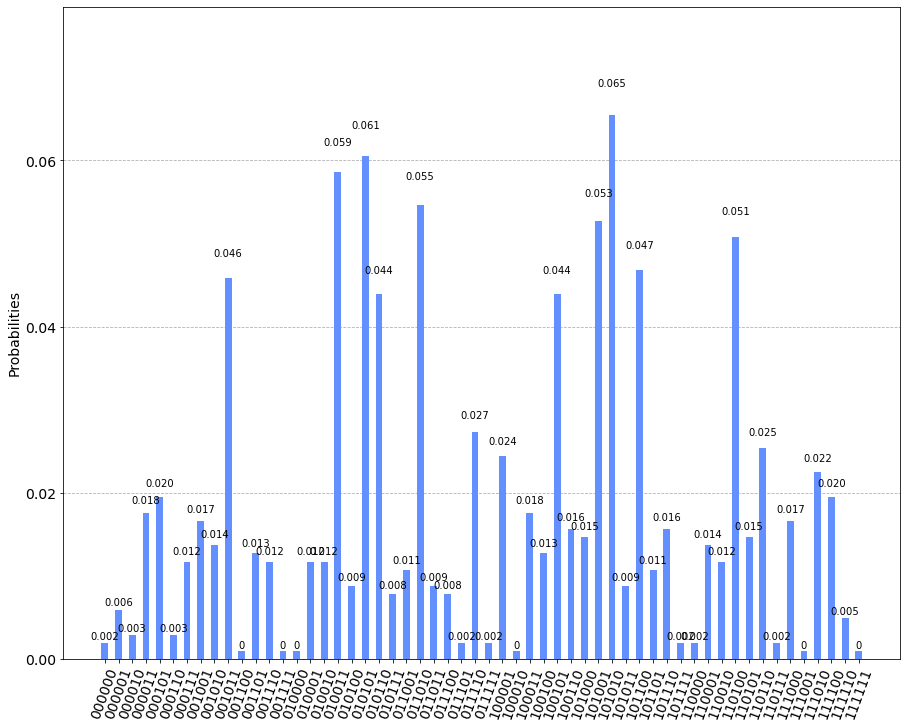

In [5]:
from qiskit.visualization import plot_histogram 

backend= Aer.get_backend("aer_simulator")
backend_shots=512 

qc_res= create_qaoa_circ(Graph, res.x)

counts=backend.run(qc_res,seed_simulator=10).result().get_counts()

plot_histogram(counts,figsize=(15,12)) 

In [6]:
maxcut("1010100",Graph)

-7

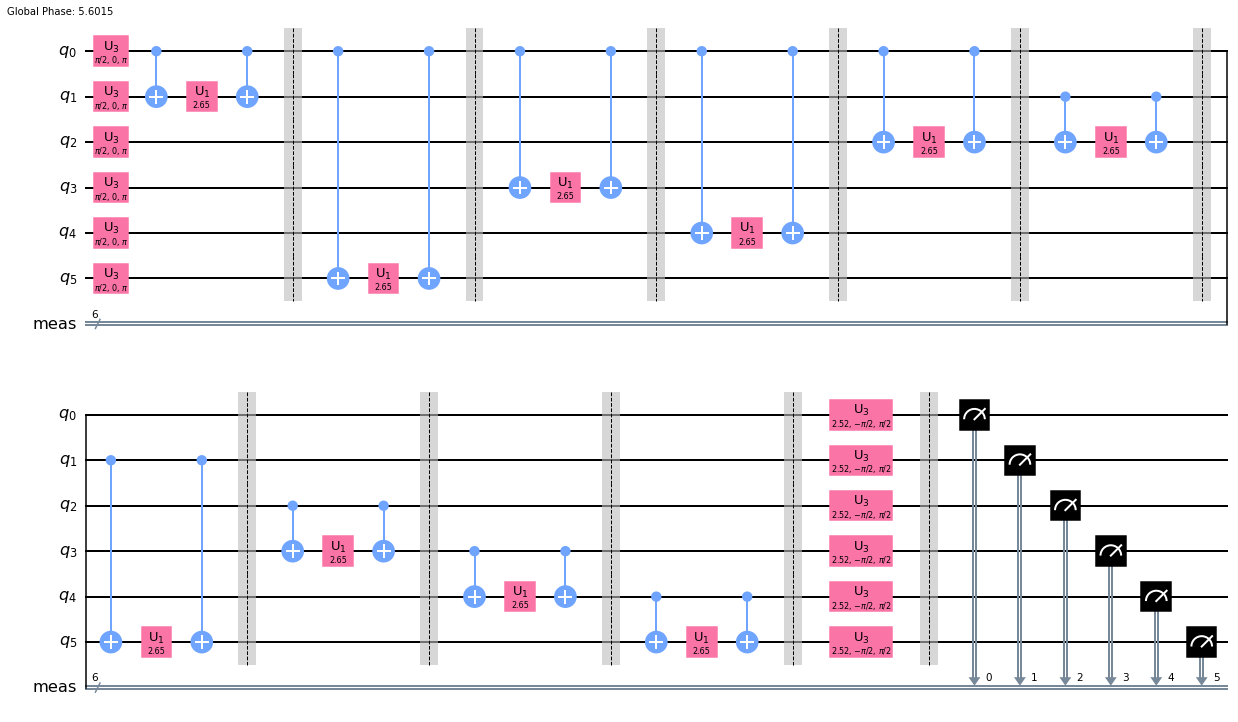

In [7]:
qc_res.decompose().decompose().draw(output='mpl')

In [8]:
from qiskit import IBMQ 
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit import transpile

IBMQ.load_account() 
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= len(Graph.nodes()) 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)


least busy backend:  ibm_oslo


In [9]:
shots = 2048
transpiled_qc = transpile(qc_res, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


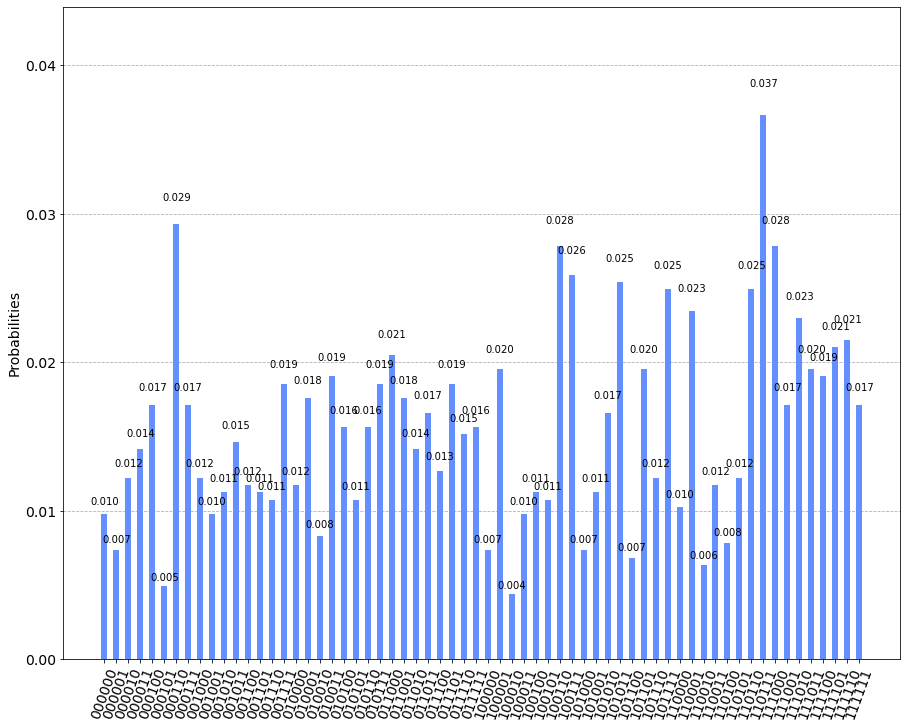

In [10]:
counts = job.result().get_counts()
plot_histogram(counts,figsize=(15,12)
              )